Choose Scheduling Algorithm (FCFS, SJF, SRTF, RR, EDF):  RR
Enter the number of processes:  1
Enter Arrival Time for Process 1 (default 0):  2
Enter Burst Time for Process 1:  3



  RR Scheduling Algorithm
Round Robin (RR) gives each process a fixed time slice (quantum) and cycles through them.



Enter time quantum:  2



Process Details:

╒═══════╤══════╤══════╤══════╤═══════╤══════╤══════╕
│   PID │   AT │   BT │   CT │   TAT │   WT │   RT │
╞═══════╪══════╪══════╪══════╪═══════╪══════╪══════╡
│     1 │    2 │    3 │    5 │     3 │    0 │    0 │
╘═══════╧══════╧══════╧══════╧═══════╧══════╧══════╛

Metrics Summary
Average Turnaround Time  : 3.00
Average Waiting Time     : 0.00
Average Response Time    : 0.00
Throughput               : 0.20 processes/unit time



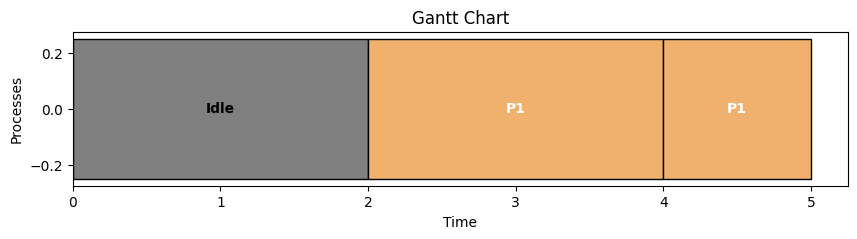

In [3]:
### 4import heapq
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
from tabulate import tabulate


def print_algorithm_info(algo):
    descriptions = {
        "FCFS": "First Come, First Serve (FCFS) executes processes in order of arrival, without preemption.",
        "SJF": "Shortest Job First (SJF) selects the process with the smallest burst time first. Can be preemptive or non-preemptive.",
        "SRTF": "Shortest Remaining Time First (SRTF) is a preemptive version of SJF, where the shortest remaining job always runs.",
        "RR": "Round Robin (RR) gives each process a fixed time slice (quantum) and cycles through them.",
        "EDF": "Earliest Deadline First (EDF) prioritizes processes with the closest deadlines in real-time systems."
    }
    print("\n" + "="*40)
    print(f"  {algo} Scheduling Algorithm")
    print("="*40)
    print(descriptions.get(algo, "Invalid Algorithm"))
    print("="*40 + "\n")

def print_process_table(processes):
    table = [[
        p.pid, p.arrival_time, p.burst_time, p.completion_time,
        p.turnaround_time, p.waiting_time, p.response_time
    ] for p in processes]

    headers = ["PID", "AT", "BT", "CT", "TAT", "WT", "RT"]
    
    print("\nProcess Details:\n")
    print(tabulate(table, headers=headers, tablefmt="fancy_grid"))  # Proper Borders

def calculate_metrics(processes, timeline):
    print_process_table(processes)
    
    avg_tat = sum(p.turnaround_time for p in processes) / len(processes)
    avg_wt = sum(p.waiting_time for p in processes) / len(processes)
    avg_rt = sum(p.response_time for p in processes) / len(processes)
    throughput = len(processes) / max(p.completion_time for p in processes)

    print("\n" + "="*30)
    print(f"Metrics Summary")
    print("="*30)
    print(f"Average Turnaround Time  : {avg_tat:.2f}")
    print(f"Average Waiting Time     : {avg_wt:.2f}")
    print(f"Average Response Time    : {avg_rt:.2f}")
    print(f"Throughput               : {throughput:.2f} processes/unit time")
    print("="*30 + "\n")

    draw_gantt_chart(timeline)

class Process:
    def __init__(self, pid, arrival_time, burst_time, deadline=None):
        self.pid = pid
        self.arrival_time = arrival_time
        self.burst_time = burst_time
        self.remaining_time = burst_time
        self.deadline = deadline  # Only set for EDF
        self.start_time = -1
        self.completion_time = 0
        self.waiting_time = 0
        self.turnaround_time = 0
        self.response_time = -1

def get_processes(edf=False):
    processes = []
    n = int(input("Enter the number of processes: "))

    for i in range(1, n + 1):
        at = int(input(f"Enter Arrival Time for Process {i} (default 0): ") or 0)
        bt = int(input(f"Enter Burst Time for Process {i}: "))
        
        deadline = None
        if edf:
            deadline = int(input(f"Enter Deadline for Process {i}: "))

        processes.append(Process(i, at, bt, deadline))
    
    return processes

def draw_gantt_chart(timeline):
    plt.figure(figsize=(10, 2))
    colors = {}  # Dictionary to store unique colors for each process
    start = 0

    for pid, duration in timeline:
        if pid not in colors:
            if isinstance(pid, str) and pid.lower() == "idle":
                colors[pid] = np.array([0.5, 0.5, 0.5])  # Fixed gray for Idle time
            else:
                colors[pid] = np.random.rand(3,)  # Random color for processes

        plt.barh(0, duration, left=start, height=0.5, align='center',
                 color=colors[pid], edgecolor="black")

        # Fixing the ValueError
        text_color = 'black' if np.array_equal(colors[pid], np.array([0.5, 0.5, 0.5])) else 'white'
        
        # Adding "P" prefix for processes
        display_name = f"P{pid}" if isinstance(pid, int) else "Idle"

        plt.text(start + duration / 2, 0, display_name, ha='center', va='center',
                 color=text_color, fontsize=10, fontweight='bold')

        start += duration

    plt.xlabel("Time")
    plt.ylabel("Processes")
    plt.title("Gantt Chart")
    plt.xticks(range(start + 1))
    plt.show()



def earliest_deadline_first(processes):
    processes.sort(key=lambda p: p.arrival_time)
    ready_queue = []
    timeline = []
    time, index, completed = 0, 0, 0

    while completed < len(processes):
        while index < len(processes) and processes[index].arrival_time <= time:
            heapq.heappush(ready_queue, (processes[index].deadline, processes[index].pid, processes[index]))
            index += 1

        if ready_queue:
            _, _, p = heapq.heappop(ready_queue)
            if p.start_time == -1:
                p.start_time = time
                p.response_time = time - p.arrival_time

            time += p.burst_time
            p.completion_time = time
            p.turnaround_time = p.completion_time - p.arrival_time
            p.waiting_time = p.turnaround_time - p.burst_time
            timeline.append((p.pid, p.burst_time))
            completed += 1
        else:
            timeline.append(("Idle", 1))
            time += 1

    return processes, timeline
# First Come First Serve (FCFS) Scheduling
def fcfs(processes):
    processes.sort(key=lambda p: p.arrival_time)
    time = 0
    timeline = []

    for p in processes:
        if time < p.arrival_time:
            timeline.append(("Idle", p.arrival_time - time))
            time = p.arrival_time

        p.start_time = time
        p.response_time = time - p.arrival_time
        time += p.burst_time
        p.completion_time = time
        p.turnaround_time = p.completion_time - p.arrival_time
        p.waiting_time = p.turnaround_time - p.burst_time
        timeline.append((p.pid, p.burst_time))

    return processes, timeline


# Shortest Job First (Non-Preemptive)
def sjf(processes):
    processes.sort(key=lambda p: (p.arrival_time, p.burst_time))
    ready_queue = []
    time, index, completed = 0, 0, 0
    timeline = []

    while completed < len(processes):
        while index < len(processes) and processes[index].arrival_time <= time:
            heapq.heappush(ready_queue, (processes[index].burst_time, processes[index].pid, processes[index]))
            index += 1

        if ready_queue:
            _, _, p = heapq.heappop(ready_queue)
            if p.start_time == -1:
                p.start_time = time
                p.response_time = time - p.arrival_time

            time += p.burst_time
            p.completion_time = time
            p.turnaround_time = p.completion_time - p.arrival_time
            p.waiting_time = p.turnaround_time - p.burst_time
            timeline.append((p.pid, p.burst_time))
            completed += 1
        else:
            timeline.append(("Idle", 0))
            time += 1

    return processes, timeline


# Shortest Remaining Time First (SRTF) Scheduling (Preemptive SJF)
def srtf(processes):
    processes.sort(key=lambda p: p.arrival_time)
    ready_queue = []
    timeline = []
    time, index, completed = 0, 0, 0
    current_process = None

    while completed < len(processes):
        while index < len(processes) and processes[index].arrival_time <= time:
            heapq.heappush(ready_queue, (processes[index].remaining_time, processes[index].pid, processes[index]))
            index += 1

        if ready_queue:
            _, _, p = heapq.heappop(ready_queue)
            if p.start_time == -1:
                p.start_time = time
                p.response_time = time - p.arrival_time

            p.remaining_time -= 1
            timeline.append((p.pid, 1))
            time += 1

            if p.remaining_time > 0:
                heapq.heappush(ready_queue, (p.remaining_time, p.pid, p))
            else:
                p.completion_time = time
                p.turnaround_time = p.completion_time - p.arrival_time
                p.waiting_time = p.turnaround_time - p.burst_time
                completed += 1
        else:
            timeline.append(("Idle", 1))
            time += 1

    return processes, timeline

def round_robin(processes, quantum=2):
    if quantum <= 0:
        print("Quantum must be greater than 0. Setting default to 2.")
        quantum = 2
    
    processes.sort(key=lambda p: p.arrival_time)  # Sort by arrival time
    time = 0
    timeline = []
    queue = deque()
    index = 0
    n = len(processes)
    
    while index < n or queue:
        if not queue:
            if index < n:
                # **Add Idle Time Before Next Process Arrives**
                if time < processes[index].arrival_time:
                    idle_time = processes[index].arrival_time - time
                    timeline.append(("Idle", idle_time))
                    time = processes[index].arrival_time
                
                queue.append(processes[index])
                index += 1
            else:
                break  

        p = queue.popleft()
        
        if p.start_time == -1:
            p.start_time = time
            p.response_time = time - p.arrival_time

        exec_time = min(p.remaining_time, quantum)
        time += exec_time
        p.remaining_time -= exec_time
        timeline.append((p.pid, exec_time))  # Track execution time

        # **Check for newly arrived processes during execution**
        while index < n and processes[index].arrival_time <= time:
            queue.append(processes[index])
            index += 1

        # **Re-add process if it has remaining time**
        if p.remaining_time > 0:
            queue.append(p)
        else:
            p.completion_time = time
            p.turnaround_time = p.completion_time - p.arrival_time
            p.waiting_time = p.turnaround_time - p.burst_time

    return processes, timeline

def main():
    algo = input("Choose Scheduling Algorithm (FCFS, SJF, SRTF, RR, EDF): ").strip().upper()
    
    if algo == "EDF":
        processes = get_processes(edf=True)
    else:
        processes = get_processes()

    print_algorithm_info(algo)

    if algo == "FCFS":
        result, timeline = fcfs(processes)
    elif algo == "SJF":
        result, timeline = sjf(processes)
    elif algo == "SRTF":
        result, timeline = srtf(processes)
    elif algo == "RR":
        quantum = int(input("Enter time quantum: "))
        result, timeline = round_robin(processes, quantum)
    elif algo == "EDF":
        result, timeline = earliest_deadline_first(processes)
    else:
        print("Invalid choice!")
        return

    calculate_metrics(result, timeline)


if __name__ == "__main__":
    main()
